<a href="https://colab.research.google.com/github/ua-chjb/water_consumption/blob/master/classification_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

ExtraaLearn is an initial stage startup that offers programs on cutting-edge technologies to students and professionals to help them upskill/reskill. With a large number of leads being generated on a regular basis, one of the issues faced by ExtraaLearn is to identify which of the leads are more likely to convert so that they can allocate the resources accordingly. You, as a data scientist at ExtraaLearn, have been provided the leads data to:

- Analyze and build an ML model to help identify which leads are more likely to convert to paid customers.
- Find the factors driving the lead conversion process.
- Create a profile of the leads which are likely to convert.

**Introduction**

This notebook looks at the limitless possibilities that exist in the education technology sector.

Over the years, a ton of nascent industries have come to the foreground - bootcamps (hello there!), kahn academy, udemy, even linkedin jumped into the fray. But where is the money flowing?

This analysis examines a small dataset of Website Leads from a startup in the EdTech space. Depending on which dataset you look at (read: copies, Feature Engineering, etc) there are ~ 20-25 features. The size of the data, 4612, always stays the same. So a very small set of data.

Overall, this analysis landed on 4 dimensions or "themes" to help guide decision making with regards to product and marketing. Those 4 areas are:
1. Digital fluency: how "online" the user is; how much they leverage the firm's digital channels
2. Referral: were they referred to the brand?
3. Current Occupation: is the user gainfully employed? Are they a student?
4. Age: what is the age of the user?

At the end of the day, this analysis landed on a clear "digital guru" buyer persona to help identify conversions with a >2x conversion rate (~85% vs 29%). This persona is identified more in the following code.

In [342]:
! jupyter nbconvert /ExtraaLearn_v4.ipynb --to html

[NbConvertApp] Converting notebook /ExtraaLearn_v4.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][143]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'Best score is: 0.8666545241749176\n'
         "Best params are: {'max_depth':..."}
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/widgetsdatatypefilter.py:71: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn(
[NbConvertApp] Writing 1860104 bytes to /ExtraaLearn_v4.html


In [1]:
import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn.metrics import confusion_matrix

import plotly.express as px
from plotly.offline import *

In [2]:
! pip install plotly==5.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1


# **Load in data**
Data can be downloaded from the repo here: [Great Learning repo](  - (https://olympus.mygreatlearning.com/courses/88643/files/8188086?module_item_id=4130791)).

Steps to access data, for new users:

- download locally
- mount on Google Drive
- upload with standard function
- check for nulls
- clean
- print a summary

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ExtraaLearn.csv to ExtraaLearn.csv


In [4]:
drs = ""
path = "ExtraaLearn.csv"
def open_data(drs, path):
    with open("".join([drs, path]), "r") as f:
        file = pd.read_csv(f)
        print(file.head())
    return file
edte = open_data(drs, path)

       ID  age current_occupation first_interaction profile_completed  \
0  EXT001   57         Unemployed           Website              High   
1  EXT002   56       Professional        Mobile App            Medium   
2  EXT003   52       Professional           Website            Medium   
3  EXT004   53         Unemployed           Website              High   
4  EXT005   23            Student           Website              High   

   website_visits  time_spent_on_website  page_views_per_visit  \
0               7                   1639                 1.861   
1               2                     83                 0.320   
2               3                    330                 0.074   
3               4                    464                 2.057   
4               4                    600                16.914   

      last_activity print_media_type1 print_media_type2 digital_media  \
0  Website Activity               Yes                No           Yes   
1  Website Activit

In [5]:
np.set_printoptions(threshold=-1)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [6]:
def DataSummary(df):

	return pd.DataFrame({'features': df.columns,'dtypes': [df.dtypes[i] for i in range(len(df.columns))],
		'nulls':[df[df.columns[i]].isnull().sum() for i in range(len(df.columns))]})

DataSummary(edte)

,features,dtypes,nulls
0,ID,object,0
1,age,int64,0
2,current_occupation,object,0
3,first_interaction,object,0
4,profile_completed,object,0
5,website_visits,int64,0
6,time_spent_on_website,int64,0
7,page_views_per_visit,float64,0
8,last_activity,object,0
9,print_media_type1,object,0


# **Exporatory Analysis: Intro**

First action: data transformation.

The question: Do any speciifc features correlate, negatively or otherwise, with the feature in question "status"?
- (converted=1, did not convert=0.)

The following section details some minor data cleaning.


In [7]:
# first steps: create a quantifiable version of the data. onehot oncoding.

edte_quant = edte.copy()

categorical_cols = ['current_occupation', 'first_interaction', 'last_activity', 'print_media_type1', 'print_media_type2', 'digital_media', 'educational_channels', 'referral']

edte_quant = pd.get_dummies(edte, columns=categorical_cols)

prof_dct = {"High": 3, "Medium": 2, "Low": 1}

edte_quant["profile_completed"] = edte_quant["profile_completed"].map(prof_dct)

DataSummary(edte_quant)

,features,dtypes,nulls
0,ID,object,0
1,age,int64,0
2,profile_completed,int64,0
3,website_visits,int64,0
4,time_spent_on_website,int64,0
5,page_views_per_visit,float64,0
6,status,int64,0
7,current_occupation_Professional,uint8,0
8,current_occupation_Student,uint8,0
9,current_occupation_Unemployed,uint8,0


With all of our features in quantifiable dataframe, the next step is to look at the correlation of these features.

# **Feature Importance**

This dataset (thankfully) does not have that many features; the number prior to feature engineering is less than <25, which is perfectly manageable. In this Notebook, we shall focus on the visuals, and go about picking out some solid insights around distributions and relationships of variables. We'll use Plotly for visual charting.

The goal: create categories based on "common sense" groupings of features.

Feature importance measurements to check:
- correlation: coefficient of determination
- covariance
- Pearson's correlation

<ipython-input-8-3160f2c1f5eb>:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-8-3160f2c1f5eb>:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



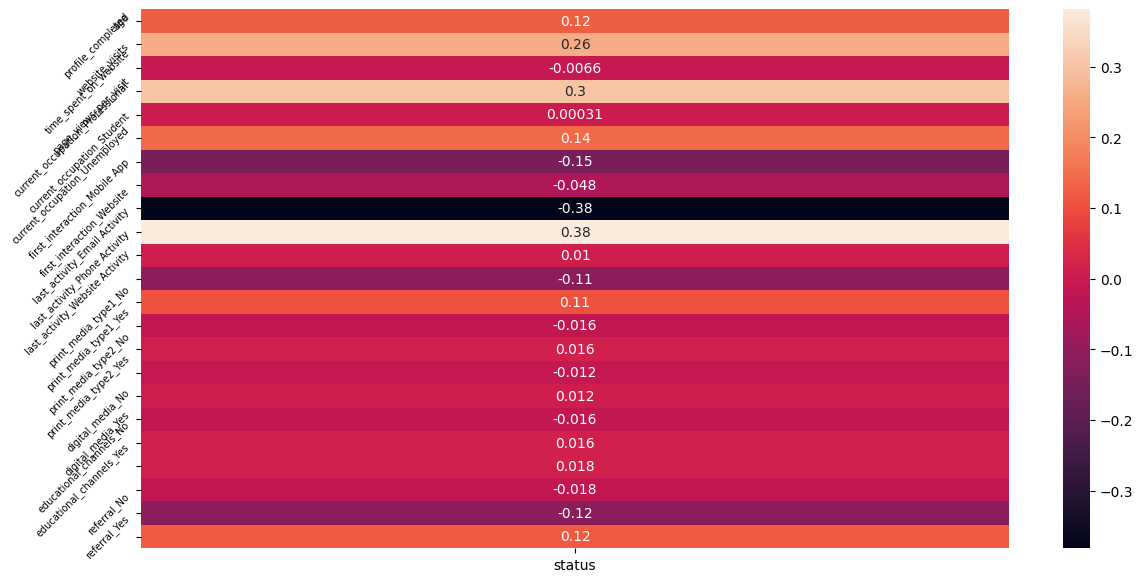

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def OneBarHeatmap(data, keyfeature, upperbound, lowerbound):
	# This function charts a single column heatmap, with one corresponding variable (keyfeature). The keyfeature is shown on the xaxis with the input variables shown on the yaxis. Data input should be in dataframe (df) format. Upperbound and lowerbound are taken as decimals.
  frame = data.corr()[(data.corr() > upperbound) | (data.corr() < lowerbound)][[keyfeature]].dropna()
  frame = frame.T.drop([keyfeature], 1).T
  width, height = 14, 7

  xticks, k, j = frame.index, 45, 7
  yticks = data[[keyfeature]].columns[::]
  plt.subplots(figsize=(width, height))
  sns.heatmap(frame, annot=True)

  plt.yticks(rotation=k, fontsize=j)
  CorrframeOne = frame[::]
  plt.show()

  return CorrframeOne

Corr = OneBarHeatmap(edte_quant, "status", 0.00, -0.00)


In [9]:
import warnings
warnings.filterwarnings("ignore")

This chart is not very clear.

It looks like the column names, on the y axis, are having some problems (x axis looks fine). This is a formatting problem - let's use Plotly for this.

In [10]:
import plotly.graph_objs as go
import plotly.figure_factory as ff

def plotly_corr_hist2d(data, keyfeature, title, ub=0, lb=0):
  frame = data.corr()[(data.corr() >= ub) | (data.corr() <= lb)][[keyfeature]].dropna()
  frame = frame.T.drop([keyfeature], 1).T.reset_index().rename(columns={"index": "features"})
  frame["keyfeature"] = keyfeature

  SCALE_3 = ["#FFFFFF", "#FFFFEF","#FFFFCD","#FFFCAA","#FFE495","#FFCA8C","#FFA05C","#FF8F6E","#FF4464"]

  trace1 = go.Histogram2d(
      x=frame.keyfeature,
      y=frame.features,
      z=np.round(frame.status, 3),
      histfunc="avg",
      texttemplate="%{z}",
      colorscale=SCALE_3 )

  f = go.Figure(data=[trace1])
  f = f.update_layout({"height": 700, "width": 1150})
  f = f.update_layout({"title": {"text": title}})

  return f, frame

pl_heatmap, corr_frame = plotly_corr_hist2d(edte_quant, "status", "Features by Conversion: Correlation Coefficient", ub=0.05, lb=-0.05)
pl_heatmap

There we are!

So: based on a threshold of +-0.05, it looks like there are 11 features to investigate. 2 fall into the category of >= mid correlation, with one positive and one negative. The third value is right on the edge.

The first 4 features are all around the theme of Digital.

Other things to note:
- website vs app: first interaction has the strongest correlation, with website positively correlatedand mobile app negatively correlated with success.
- profile completion and time spent on website: these take home the next 2 feature spots, which are again both around the idea of **digital**. It looks like the more a user is comfortable in the digital ecosystem, the more likely they are to convert.
- age has a correlation above the threshold. But as we'll see, this variable has peaks and valleys from 18-75.
- referral: this feature falls into the category of "a little correlation".
- current occupation: "student" and "employed" categories have the highest correlation. This will boil down to a strategy question - both are decent markets, and one could conceivably create products in either space (B2B or B2C). This analysis will lay out the data for each use case.

However, before we get into recommendations, let's take a step back and double check our feature importance with covariance.

In [11]:
def plotly_cov_hist2d(data, keyfeature, title):

  cov_df = data.cov()[[keyfeature]]
  cov_df = cov_df.sort_values(by=[keyfeature], ascending=True).T.drop(["status"], 1).T.reset_index().rename(columns={"index": "features"})
  cov_df["keyfeature"] = keyfeature

  SCALE_3 = ["#FFFFFF", "#FFFFEF","#FFFFCD","#FFFCAA","#FFE495","#FFCA8C","#FFA05C","#FF8F6E","#FF4464"]

  trace1 = go.Histogram2d(
      x=cov_df.keyfeature,
      y=cov_df.features,
      z=cov_df.status,
      histfunc="avg",
      texttemplate="%{z}",
      colorscale=SCALE_3 )

  f = go.Figure(data=[trace1])
  f = f.update_layout({"height": 700, "width": 1000})
  f = f.update_layout({"title": {"text": title}})

  return f, cov_df

f, cov_df = plotly_cov_hist2d(edte_quant, "status", "Cov, Features and Conversion")
f

Woah!

"Time spent on website" is definitely something thing to focus on.

Quite surprising that the covaraince of the top feature is around 200-500x that of the next feature. However, this lines up with the Digital theme - If the insights from the data are lining up, that's usually a good indication that those insights can safely be projected into the future. Always a breath of fresh air when new insights follow the same trajectory, and even better when that trajectory tends to be good.

In [12]:
def plotly_cov_hist2d(data, keyfeature, title1, title2):
  # note: this function removed outlier (pos) from cov dataframe, as it was close to between 100-500x the next largets number of row[1].
  # df1 and f1 remove outliers with the traditional IQR method.
  # df2 and f2 remove the "outlier" (the 100-500x datapoint) and keep the other datapoints, which are technically outside the IQR, but still +-1.0 of the other datapoints
  # (for reference, the 100-500x datapoint has a value ~102).

  cov_df = data.cov()[[keyfeature]]
  cov_df = cov_df.sort_values(by=[keyfeature], ascending=True).T.drop(["status"], 1).T.reset_index().rename(columns={"index": "features"})
  cov_df["keyfeature"] = keyfeature

  SCALE_3 = ["#FFFFFF", "#FFFFEF","#FFFFCD","#FFFCAA","#FFE495","#FFCA8C","#FFA05C","#FF8F6E","#FF4464"]

  # outlier detection, method 1
  q1=np.quantile(cov_df[keyfeature], 0.25)
  q2=np.median(cov_df[keyfeature])
  q3=np.quantile(cov_df[keyfeature], 0.75)
  iqr=q3-q1
  lowerfence=q1-(1.5*iqr) if q1-(1.5*iqr) > min(cov_df[keyfeature]) else min(cov_df[keyfeature])
  upperfence=q3+(1.5*iqr) if q3+(1.5*iqr) < max(cov_df[keyfeature]) else max(cov_df[keyfeature])
  outliers = (cov_df[keyfeature] > upperfence) | (cov_df[keyfeature] < lowerfence)
  cov_df1 = cov_df[~outliers]

  trace1 = go.Histogram2d(
    x=cov_df1.keyfeature,
    y=cov_df1.features,
    z=np.round(cov_df1.status, 3),
    histfunc="avg",
    texttemplate="%{z}",
    colorscale=SCALE_3)

  f1 = go.Figure(data=[trace1])
  f1 = f1.update_layout({"height": 700, "width": 1000})
  f1 = f1.update_layout({"title": {"text": title1}})

  # outlier detection, method 2
  cov_df2 = cov_df.set_index("features").T.drop(["time_spent_on_website"], 1,).T.reset_index()

  trace0 = go.Histogram2d(
    x=cov_df2.keyfeature,
    y=cov_df2.features,
    z=np.round(cov_df2.status.astype(float), 3),
    histfunc="avg",
    texttemplate="%{z}",
    colorscale=SCALE_3)

  f2 = go.Figure(data=[trace0])
  f2 = f2.update_layout({"height": 700, "width": 1000})
  f2 = f2.update_layout({"title": {"text": title2}})

  return cov_df1, cov_df2, f1, f2

cov_df0, cov_df2, f0, f2 = plotly_cov_hist2d(edte_quant, "status", "Cov, Features and Conversion (outliers removed via IQR method)", "Cov, Features and Conversion (outliers removed eyeball method)")

In [13]:
# outliers removed via IQR method
f0

In [14]:
# outliers removed via eyeball method
f2

These two charts parse the covariance further.

Outliers were removed from the original cov chart, because it wasn't possible to see the values of the rest of the features.

However, the traditional IQR method of outlier detection removed outliers that weren't visible initially, but also weren't in the cleaned up, outlier-free chart. That's because they fell in a sort of "danger zone". In cases like this, it's safest to double check why that anamoly was present.
So this was more of "eyeballing it out".

~~

At the end of the day, the two charts with outlier detection are really just reaffirming the need to investigate those secondary and tertiary features.

In [19]:
def layout_func(fig):
    fig.update_layout(
        dict(
            paper_bgcolor=paper_bgcolor,
            plot_bgcolor=plot_bgcolor,
            clickmode="select",
            xaxis=dict(
                zeroline=False
                ),
            yaxis=dict(
                zeroline=False
                ),
            )
        )

    return fig

SCALE_3 = [
    "#FFFFEF",
    "#FFFFCD",
    "#FFFCAA",
    "#FFE495",
    "#FFCA8C",
    "#FFA05C",
    "#FF8F6E",
    "#FF4464",
    ]

paper_bgcolor="white"
plot_bgcolor="#faf8f8"
font_color="#0c0c0c"
colorscale=SCALE_3

Finally, with Pearson's Correlation, we get a a final confirmation on feature importance.

In [20]:
corr_frame["status"] = np.round(corr_frame["status"] ** 2, 4)

In [22]:
corr_frame = corr_frame.sort_values(by=["status"])
layout_func(px.bar(corr_frame, y="features", x="status", orientation="h", color="status", color_continuous_scale=colorscale[3:]).update_layout({"title": {"text": "Pearson's Correlation, Top Features"}}))

# **Feature Importance: Summary**

The #1 priority is Digital fluency: a sum of features around how the user experiences the brand on digital channels. This includes the site, the app, profile completion, email, etc.

In total, there are 4 areas to focus on:
- Digital fluency
- Current Occupation
- Age
- Were they referred

# **Dim 1: Age**

The first dimension to examine is that of age.



In [23]:
layout_func(px.histogram(edte_quant, x="age", color_discrete_sequence=colorscale[4:]).update_layout({"title": {"text": "Age Distribution"}}))

There are a few things to note here.
1. A large spike around 55-60, which could either (A) be a "return to work" movement or (B) a sign of severe layoffs within that age demographic.
2. The student population, 18-25, has a stable frequency, but is too young to be an option as a viable target market.
3. The spike at 32 could indicate a few things.
  - first, that the younger generation has it rough. It seems that there's a linear increase in interest level (at least on the frequency side) with users aged 25-31, where the "go-getters" are the target users who are learning the new skills - but these users are few and far between.
  - Second, the huge spike could be a split. It looks like frequency is consistently higher after 31, which may indicate that 31 is turning point in this generation's way of thinking about who they want to be in their work. If we really look at the data (n is >= 30) it seems that interest decreases 32-40, as more senior roles are associated with softer skills vs hard skills. Then, past 40, it goes up again, as people tend to stop caring, and are more likely to quote unquote "just go for it."
  - Either way, nothing compares with the spike of the older market.


In [24]:
edte_age_gb = edte_quant.groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()
layout_func(px.bar(edte_age_gb, x="age", y="Size", color="Average", color_continuous_scale=colorscale[::]).update_layout({"title": {"text": "Age by Conversion, with Color as Conversion Rate"}, "yaxis": {"title": {"text": "Size"}}}))

Looks like our instincts around students was true!

- Students have a low conversion rate, consistently on the lower side of 0.15.
- The "Return to New" market of the 55-60 age group has conversion rates ~30-36%, compared with the average 29%.
- The "Young Professionals" increases linearly over time, with the rate at the end of their segment landing exactly on the average.
- The rest of the market, 32-54, is a crap shoot, with no easily decipherable pattern.

In [25]:
edte_quant["age_segment"] = np.zeros(len(edte_quant))

edte_quant["age_segment"][edte_quant.age <= 24] = "24-"
edte_quant["age_segment"][(edte_quant.age >= 25) & (edte_quant.age <= 31)] = "25-31"
edte_quant["age_segment"][(edte_quant.age >= 32) & (edte_quant.age <= 39)] = "32-39"
edte_quant["age_segment"][(edte_quant.age >= 40) & (edte_quant.age <= 54)] = "40-54"
edte_quant["age_segment"][(edte_quant.age >= 55) & (edte_quant.age <= 60)] = "55-60"
edte_quant["age_segment"][(edte_quant.age >= 61)] = "61+"
edte_quant["age_segm"] = edte_quant["age_segment"]

edte_quant = pd.get_dummies(edte_quant, columns=["age_segm"])

In [26]:
edte_age_gb = edte_quant.groupby(["age_segment"]).agg({"status": ["mean", "std", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "mean", 1: "std", 2: "count"}).reset_index()
edte_age_gb

,age_segment,mean,std,count
0,24-,0.117329,0.322102,554.0
1,25-31,0.303665,0.461048,191.0
2,32-39,0.300633,0.458896,632.0
3,40-54,0.313156,0.463964,1239.0
4,55-60,0.346216,0.475891,1863.0
5,61+,0.233083,0.424393,133.0


In [27]:
edte_quant.status.mean()

0.29856895056374677

In [28]:
seg0 = edte_quant.groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
age_seg01 = edte_quant[edte_quant.age_segment=="24-"].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
age_seg02 = edte_quant[edte_quant.age_segment=="25-31"].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
age_seg03 = edte_quant[edte_quant.age_segment=="32-39"].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
age_seg04 = edte_quant[edte_quant.age_segment=="40-54"].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
age_seg05 = edte_quant[edte_quant.age_segment=="55-60"].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
age_seg06 = edte_quant[edte_quant.age_segment=="61+"].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values

In [29]:
from scipy.stats import norm

def multi_pdf(x1, x2, x3, x4, x5, name1="seg1", name2="seg2", name3="seg3", name4="seg4", name5="seg5"):

  mu1, sigma1 = x1.mean(), x1.std()
  density1 = np.linspace(x1.min(), x1.max(), 100)
  pdf1 = norm.pdf(density1, mu1, sigma1)

  mu2, sigma2 = x2.mean(), x2.std()
  density2 = np.linspace(x2.min(), x2.max(), 100)
  pdf2 = norm.pdf(density2, mu2, sigma2)

  mu3, sigma3 = x3.mean(), x3.std()
  density3 = np.linspace(x3.min(), x3.max(), 100)
  pdf3 = norm.pdf(density3, mu3, sigma3)

  mu4, sigma4 = x4.mean(), x4.std()
  density4 = np.linspace(x4.min(), x4.max(), 100)
  pdf4 = norm.pdf(density4, mu4, sigma4)

  mu5, sigma5 = x5.mean(), x5.std()
  density5 = np.linspace(x5.min(), x5.max(), 100)
  pdf5 = norm.pdf(density5, mu5, sigma5)


  trace0 = go.Scatter(
      x=density1,
      y=pdf1,
      mode="lines",
      marker=dict(color=colorscale[4]),
      name=name1)

  trace1 = go.Scatter(
      x=density2,
      y=pdf2,
      mode="lines",
      marker=dict(color=colorscale[3]),
      name=name2,
      visible="legendonly")

  trace2 = go.Scatter(
      x=density3,
      y=pdf3,
      mode="lines",
      marker=dict(color=colorscale[6]),
      name=name3)

  trace3 = go.Scatter(
      x=density4,
      y=pdf4,
      mode="lines",
      marker=dict(color=colorscale[6]),
      name=name4,
      visible="legendonly")

  trace4 = go.Scatter(
      x=density5,
      y=pdf5,
      mode="lines",
      marker=dict(color=colorscale[6]),
      name=name5,
      visible="legendonly")


  f = go.Figure(data=[trace0, trace1, trace2, trace3, trace4])

  return f, trace0, trace1, trace2

x1 = seg0
x2 = age_seg01
x3 = age_seg02
x4 = age_seg04
x5 = age_seg05

f1, f1_t0, f1_t1, f1_t2 = multi_pdf(x1, x2, x3, x4, x5, name1="Entire sample", name2="24-", name3="25-31", name4="40-54", name5="55-60")

f1 = layout_func(f1.update_layout({"title": {"text": "Age Segments, Conversion Rate"},
     "xaxis": {"title": {"text": "Conversion Rate"}},
     "yaxis": {"title": {"text": "Frequency"}}})
)
iplot(f1)

In [65]:
slope_lst = []

for age_seg in list(edte_quant["age_segment"].value_counts().index):

  x = edte_quant[edte_quant.age_segment==age_seg][["age"]]
  y = edte_quant[edte_quant.age_segment==age_seg]["status"].values

  lin = linear_model.LinearRegression()

  slope_lst.append(lin.fit(x, y).coef_)

edte_age_gb["slope"] = [m[0] for m in slope_lst]

In [70]:
x = edte_quant[["age"]]
y = edte_quant["status"].values

lin = linear_model.LinearRegression()

lin.fit(x, y)

print(lin.coef_)

[0.00424537]


In [56]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=edte_quant["status"], groups=edte_quant['age_segment'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   24-  25-31   0.1863    0.0  0.0781 0.2946   True
   24-  32-39   0.1833    0.0  0.1082 0.2584   True
   24-  40-54   0.1958    0.0  0.1299 0.2617   True
   24-  55-60   0.2289    0.0  0.1665 0.2913   True
   24-    61+   0.1158 0.0858 -0.0088 0.2403  False
 25-31  32-39   -0.003    1.0 -0.1095 0.1035  False
 25-31  40-54   0.0095 0.9998 -0.0908 0.1097  False
 25-31  55-60   0.0426 0.8181 -0.0554 0.1405  False
 25-31    61+  -0.0706 0.7382 -0.2162 0.0751  False
 32-39  40-54   0.0125 0.9932 -0.0505 0.0756  False
 32-39  55-60   0.0456  0.243 -0.0138  0.105  False
 32-39    61+  -0.0676 0.6217 -0.1906 0.0555  False
 40-54  55-60   0.0331 0.3461 -0.0142 0.0803  False
 40-54    61+  -0.0801 0.3778 -0.1978 0.0376  False
 55-60    61+  -0.1131 0.0598 -0.2289 0.0026  False
---------------------------------------------------


In [69]:
0.346216 - edte_quant.status.mean()

0.04764704943625325

In [66]:
edte_age_gb

,age_segment,mean,std,count,slope
0,24-,0.117329,0.322102,554.0,-0.006318
1,25-31,0.303665,0.461048,191.0,0.000529
2,32-39,0.300633,0.458896,632.0,0.008560
3,40-54,0.313156,0.463964,1239.0,-0.006316
4,55-60,0.346216,0.475891,1863.0,0.026079
5,61+,0.233083,0.424393,133.0,-0.001158


# **Summary: Age**

Main takeaway:
1. The 24- group had statistical significance that held in 4/5 groups.

Other insights:
- With 32-39s, the rate saw a dip. This had a positive directionality associate with it.
- The 25-31s also had a positive directionality, with a slope of 0.001.
- The 40-54s had a negative directionality as well as a higher average of 31.3%.
- The 55-60s had a 5% higher average, in terms of conversion, but also had a positive slope at 0.026%.

# **Dim2: Current Occupation**

Next, let's look at current occupation data.

In [225]:
edte_age_co_gb = edte.groupby(["age", "current_occupation"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()

In [231]:
SCALE_5 = ["#FFE495","#FFCA8C","#FFA05C",]

layout_func(px.histogram(edte,x="age",color="current_occupation",color_discrete_sequence=SCALE_5[::-1]).update_layout({"title": {"text": "Distributions of Current Occupations, by Age"}}))

The spike at 32 was due to a round of firing.

From a cause and effect perspective, this would explain why frequency tended to increase past 33 - one reason for the decrease in conversion could also be attributed to this increase, as a larger base value naturally solidifies a ratio.

In terms of the even larger 55-60 segment, the majority of this segment is gainfully employed. This could be an interesting insight in the consideration of product offerings.

In [82]:
trace1 = go.Histogram2d(
    x=edte_age_co_gb.age,
    y=edte_age_co_gb.current_occupation,
    z=np.round(edte_age_co_gb.Average, 2),
    histfunc="avg",
    xbins=dict(size=1),
    colorscale=SCALE_3 )

g = go.Figure(data=[trace1]).update_layout({"title": {"text": "Conversion, by Age and Profession"}})
g

Again, we see that the Professional market is quite appealing, with high conversion rates overall.

In [228]:
edte["age_segment"] = edte_quant["age_segment"]
edte_ageseg_co_gb = edte.groupby(["age_segment", "current_occupation"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()

SCALE_5 = ["#FFE495","#FFCA8C","#FFA05C",]

h = px.bar(edte_ageseg_co_gb,
       x="age_segment",
       y="Average",
       color="current_occupation",
       barmode="group",
       color_discrete_sequence=SCALE_5)

layout_func(h).update_layout({"title":{"text": "Current Occupation, Avg Conversion Rates"}, "yaxis": {"title":{"text": "Ratio of Conversion"}}})

Distributed by age segment, this becomes a bit more confsing. The differences segment 1 and 2 and 3 are meaningful, but between 2 and 3, less so.

Professionals do beat out the Unemployed at every age segment, even if just barely.

In [167]:
edte_age_co_gb = edte.groupby(["age", "current_occupation"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()

g = px.scatter_3d(
    edte_age_co_gb,
    x="age",
    y="current_occupation",
    z="Average",
    size="Size",
    symbol="current_occupation",
    color="Average",
    color_continuous_scale=SCALE_3,
    symbol_sequence = ['diamond-open', 'cross','circle-open']).update_traces(marker=dict(
        size=edte_age_co_gb.Size.values*20
        )).update_layout({"title": {"text": "Current Occupation and Age, Conversion Rate"},
                          "scene": {"xaxis": {"title": {"text": "Age"}},
                                    "yaxis": {"title": {"text": ""}},
                                    "zaxis": {"title": {"text": "% Status"}}},
                 "coloraxis_colorbar": {"yanchor":"top", "y":1, "x":0}})

layout_func(g)


The benefit of Professionls is clear: higher conversion rate, larger market, more stability.

But the Unemployed market shouldn't be overlooked: Unemployed users are oftentimes eager to start upskilling ASAP. The market is fairly large as well.

Ultimately, this comes down to a product question. Statistics are presented below.

In [233]:
tukey = pairwise_tukeyhsd(endog=edte["status"], groups=edte['current_occupation'], alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
Professional    Student   -0.238   0.0 -0.2874 -0.1886   True
Professional Unemployed  -0.0893   0.0  -0.124 -0.0546   True
     Student Unemployed   0.1487   0.0  0.0958  0.2015   True
-------------------------------------------------------------


In [330]:
layout_func(px.bar(edte_prof_gb.sort_values(by=["mean"], ascending=True), x="mean", y="current_occupation", color="count", color_continuous_scale=colorscale[3:7]).update_layout({"title": {"text": "Conversion Rate, by Profession"}}))

In [236]:
edte_prof_gb = edte.groupby(["current_occupation"]).agg({"status": ["mean", "std", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "mean", 1: "std", 2: "count"}).reset_index()
edte_prof_gb1 = edte_prof_gb[edte_prof_gb["current_occupation"].isin(["Professional", "Unemployed"])]
edte_prof_gb1

edte_prof_gb

,current_occupation,mean,std,count
0,Professional,0.355122,0.478642,2616.0
1,Student,0.117117,0.321850,555.0
2,Unemployed,0.265788,0.441905,1441.0


In [237]:
seg0 = edte_quant.groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
co_seg1 = edte_quant[(edte_quant.current_occupation_Student==1)].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
co_seg2 = edte_quant[(edte_quant.current_occupation_Unemployed==1)].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
co_seg3 = edte_quant[(edte_quant.current_occupation_Professional==1)].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values

In [238]:
from scipy.stats import norm

def multi_pdf(x1, x2, x3, x4, name1="seg1", name2="seg2", name3="seg3", name4="seg4"):

  mu1, sigma1 = x1.mean(), x1.std()
  density1 = np.linspace(x1.min(), x1.max(), 100)
  pdf1 = norm.pdf(density1, mu1, sigma1)

  mu2, sigma2 = x2.mean(), x2.std()
  density2 = np.linspace(x2.min(), x2.max(), 100)
  pdf2 = norm.pdf(density2, mu2, sigma2)

  mu3, sigma3 = x3.mean(), x3.std()
  density3 = np.linspace(x3.min(), x3.max(), 100)
  pdf3 = norm.pdf(density3, mu3, sigma3)

  mu4, sigma4 = x4.mean(), x4.std()
  density4 = np.linspace(x4.min(), x4.max(), 100)
  pdf4 = norm.pdf(density4, mu4, sigma4)

  trace0 = go.Scatter(
      x=density1,
      y=pdf1,
      mode="lines",
      marker=dict(color=colorscale[4]),
      visible="legendonly",
      name=name1)

  trace1 = go.Scatter(
      x=density2,
      y=pdf2,
      mode="lines",
      marker=dict(color=colorscale[5]),
      name=name2 )

  trace2 = go.Scatter(
      x=density3,
      y=pdf3,
      mode="lines",
      marker=dict(color=colorscale[6]),
      name=name3)

  trace3 = go.Scatter(
      x=density4,
      y=pdf4,
      mode="lines",
      marker=dict(color=colorscale[7]),
      name=name4)


  f = go.Figure(data=[trace0, trace1, trace2, trace3])

  return f, trace0, trace1, trace2, trace3

x1 = seg0
x2 = co_seg1
x3 = co_seg2
x4 = co_seg3

f2, f2_t0, f2_t1, f2_t2, f2_t3 = multi_pdf(x1, x2, x3, x4, name1="Average pop", name2="Student Segment", name3="Unemployed Segment", name4="Professional Segment")

f2.update_layout({"title": {"text": "Profession Segments, Conversion Rate"},
     "xaxis": {"title": {"text": "Conversion Rate"}},
     "yaxis": {"title": {"text": "Frequency"}},
     "paper_bgcolor": paper_bgcolor, "plot_bgcolor": "#faf8f8"})

iplot(f2)

# **Summary: Current Occupation**

Main takeaways:
1. Professionals are the most appealing market, based on the data
  - Conversion rate is higher
  - Size of market is larger
  - Distribution of age is more appealing
2. Unemployed market is also appealing
  - Second highest conversion
  - Second largest market
  - Distribution od age is less appealing

Other insights:
- the student population is generally one to overlook. With that being said, it could be interesting to see if an early enagement could produce attribution further down the funnel.

# **Dim3: Digital fluency**

Next up is digital fluency.

This variable is somewhat more complex - rather than approach from a Demographic angle, we need to look at it from a "user behavior" angle.What are the user behaviors that lead to a conversion? What do we imagine the most digitally fluent users would do?
- first interaction: website or app
- website: with Pearson's Correlation we can use the following 2 features, then revisit if we're not happy with the accuracy scores
  - time on site: continuous, qcut into quartiles
  - profile completion: high, medium, or low
- last activity: email, website, or phone

In [239]:
edte_quant["time_spent_on_website_quant"] = pd.qcut(edte_quant["time_spent_on_website"], 4, labels=range(1,5))
edte["time_spent_on_website_quant"] = pd.qcut(edte["time_spent_on_website"], 4, labels=range(1,5))

In [240]:
# mean of website vs app
edte.groupby(["first_interaction"]).agg({"status": ["mean", "std", "count"]})

status                
                       mean       std count
first_interaction                          
Mobile App         0.105314  0.307032  2070
Website            0.455940  0.498153  2542

In [241]:
# mean across all users
edte.status.mean()

0.29856895056374677

In [242]:
# statistical significance is present
tukey = pairwise_tukeyhsd(endog=edte["status"], groups=edte['first_interaction'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1    group2 meandiff p-adj lower  upper  reject
------------------------------------------------------
Mobile App Website   0.3506   0.0 0.3261 0.3752   True
------------------------------------------------------


**first interaction**: We reject the null in favor of the alternative, that there is a significant difference among the two samples of "website" and "app". This means that there likely is a difference, whether in UX or other, between the app and the mobile site.

In [243]:
edte.groupby(["last_activity"]).agg({"status": ["mean", "std", "count"]})

status                
                      mean       std count
last_activity                             
Email Activity    0.303336  0.459800  2278
Phone Activity    0.213128  0.409683  1234
Website Activity  0.384545  0.486709  1100

In [244]:
tukey = pairwise_tukeyhsd(endog=edte["status"], groups=edte['last_activity'], alpha=0.05)
print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1          group2      meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------
Email Activity   Phone Activity  -0.0902   0.0 -0.1278 -0.0526   True
Email Activity Website Activity   0.0812   0.0  0.0422  0.1203   True
Phone Activity Website Activity   0.1714   0.0  0.1273  0.2155   True
---------------------------------------------------------------------


**Last activity**: We reject the null in favor of the alternative, that there is a significant difference among the three samples of "phone", "email", and "app". This means that there likely is a difference, in some form of customer experience or influence, between the phone, email, and website as last activity.

In [245]:
edte.groupby(["time_spent_on_website_quant"]).agg({"status": ["mean", "std", "count"]})

status                
                                 mean       std count
time_spent_on_website_quant                          
1                            0.151778  0.358961  1153
2                            0.136915  0.343907  1154
3                            0.408854  0.491836  1152
4                            0.496964  0.500208  1153

In [246]:
tukey = pairwise_tukeyhsd(endog=edte["status"], groups=edte['time_spent_on_website_quant'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0149 0.8401 -0.0609 0.0311  False
     1      3   0.2571    0.0  0.2111 0.3031   True
     1      4   0.3452    0.0  0.2992 0.3912   True
     2      3   0.2719    0.0  0.2259 0.3179   True
     2      4     0.36    0.0   0.314 0.4061   True
     3      4   0.0881    0.0  0.0421 0.1341   True
---------------------------------------------------


**Time spent on site**: With most segments (read: all segments but 1 and 2), the alternative wins out; that is, we reject the null that the difference in conversion rates among segments is just due to random chance. There is a statistical difference in conversion rates between people who spent a lot of time on the website and a little time on the website.

In [247]:
edte.groupby(["profile_completed"]).agg({"status": ["mean", "std", "count"]})

status                
                       mean       std count
profile_completed                          
High               0.417845  0.493313  2264
Low                0.074766  0.264252   107
Medium             0.188755  0.391401  2241

In [248]:
tukey = pairwise_tukeyhsd(endog=edte["status"], groups=edte['profile_completed'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  High    Low  -0.3431   0.0 -0.4456 -0.2405   True
  High Medium  -0.2291   0.0   -0.26 -0.1982   True
   Low Medium    0.114 0.025  0.0114  0.2166   True
---------------------------------------------------


**Profile completed**: We reject the null in favor of the alternative, that there is a significant difference among the three categories of profile completion. This stands to reason; however, the conversion rate of of the "most completed" segment is much quite good - better than any other unique segment we've identified so far. This could be something to think about when we consider the competitive advantage of the website.

In [249]:
edte.groupby(["profile_completed", "time_spent_on_website_quant"]).agg({"status": ["mean", "std", "count"]})

status                
                                                   mean       std count
profile_completed time_spent_on_website_quant                          
High              1                            0.301616  0.459372   557
                  2                            0.271863  0.445343   526
                  3                            0.512953  0.500264   579
                  4                            0.561462  0.496621   602
Low               1                            0.088235  0.287902    34
                  2                            0.088889  0.287799    45
                  3                            0.043478  0.208514    23
                  4                            0.000000  0.000000     5
Medium            1                            0.007117  0.084139   562
                  2                            0.018868  0.136175   583
                  3                            0.314545  0.464757   550
                  4                            0.430403  0.495587   546

In [250]:
edte.groupby(["first_interaction","last_activity", "profile_completed", "time_spent_on_website_quant"]).agg({"status": ["mean", "std", "count"]})

status  \
                                                                                      mean   
first_interaction last_activity    profile_completed time_spent_on_website_quant             
Mobile App        Email Activity   High              1                            0.000000   
                                                     2                            0.008772   
                                                     3                            0.190476   
                                                     4                            0.198529   
                                   Low               1                            0.000000   
                                                     2                            0.000000   
                                                     3                            0.000000   
                                                     4                                 NaN   
                                   Medium            1                            0.000000   
                                                     2                            0.038168   
                                                     3                            0.121739   
                                                     4                            0.162162   
                  Phone Activity   High              1                            0.000000   
                                                     2                            0.000000   
                                                     3                            0.132353   
                                                     4                            0.175000   
                                   Low               1                            0.000000   
                                                     2                            0.000000   
                                                     3                            0.000000   
                                                     4                            0.000000   
                                   Medium            1                            0.000000   
                                                     2                            0.000000   
                                                     3                            0.041667   
                                                     4                            0.131579   
                  Website Activity High              1                            0.000000   
                                                     2                            0.000000   
                                                     3                            0.343750   
                                                     4                            0.305085   
                                   Low               1                            0.000000   
                                                     2                            0.000000   
                                                     3                            0.000000   
                                                     4                            0.000000   
                                   Medium            1                            0.000000   
                                                     2                            0.000000   
                                                     3                            0.397059   
                                                     4                            0.541667   
Website           Email Activity   High              1                            0.558442   
                                                     2                            0.523077   
                                                     3                            0.801370   
                                                     4                            0.882353   
                                   Low    

Altogether, what does this journey look like? How frequent are digital gurus?

In [251]:
dims = [
    {"values": edte["first_interaction"],
    "label": "First Interaction",
    "categoryorder": "category ascending"},

    {"values": edte["time_spent_on_website_quant"],
    "label": "Website - time spent on site",
    "categoryorder": "category descending"},

    {"values": edte["profile_completed"],
    "label": "Profile Completed",
    "categoryorder": "category descending"},

    {"values": edte["last_activity"],
    "label": "Last Activity",
    "categoryorder": "category descending"},

    {"values": edte["status"],
    "label": "Converted",
    "categoryorder": "category descending"},

]

trace0 = go.Parcats(
    dimensions=dims,
    line={'color': edte["status"], 'colorscale': colorscale[4::2]})

fig = go.Figure(data=trace0).update_layout({"title": {"text": "Digital Touchpoints, as a Journey"}})
fig2 = layout_func(fig)
iplot(fig2)

The digital guru journey:
- First interaction on the site, whether through search engine, referral, blog, or an ad.
- browse around, read content, decide whether this is the program for them. website is huge here: 4x conversion on website vs app.
- eventually complete profile (without being bothered to do so), not because they have to, but just because it's "something to do"
- last activity on website - they literally never have to talk to anyone :)

In [255]:
edte["digital_guru"] = np.zeros(len(edte))

edte["digital_guru"][(edte["first_interaction"]=="Website") & (edte["profile_completed"]=="High") &
                     ((edte["time_spent_on_website_quant"]==3) | (edte["time_spent_on_website_quant"]==4)) &
                     ((edte["last_activity"]=="Email Activity") | (edte["last_activity"]=="Website Activity"))] = 1

And a quick visual of conversion rates as a PDF.

In [254]:
seg0 = edte.groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
digi_seg1 = edte[edte["digital_guru"]==1].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values

def multi_pdf(x1, x2, name1="general pop", name2="seg1"):

  mu1, sigma1 = x1.mean(), x1.std()
  density1 = np.linspace(x1.min(), x1.max(), 100)
  pdf1 = norm.pdf(density1, mu1, sigma1)

  mu2, sigma2 = x2.mean(), x2.std()
  density2 = np.linspace(x2.min(), x2.max(), 100)
  pdf2 = norm.pdf(density2, mu2, sigma2)

  trace0 = go.Scatter(
      x=density1,
      y=pdf1,
      mode="lines",
      marker=dict(color=colorscale[4]),
      name=name1)

  trace1 = go.Scatter(
      x=density2,
      y=pdf2,
      mode="lines",
      marker=dict(color=colorscale[6]),
      name=name2 )


  f = go.Figure(data=[trace0, trace1])

  return f, trace0, trace1

x1 = seg0
x2 = digi_seg1

f3, f3_t0, f3_t1= multi_pdf(x1, x2, name1="Average pop", name2="Digital guru segment")

f3.update_layout(
    {"title": {"text": "Digital Gurus, Conversion Rate"},
     "xaxis": {"title": {"text": "Conversion Rate"}},
     "yaxis": {"title": {"text": "Frequency"}},
     "paper_bgcolor": paper_bgcolor, "plot_bgcolor": "#faf8f8"})

f3_t0, f3_t1 = trace0, trace1

iplot(f3)

# **Summmary: Digital Gurus**

Main takeaway:
1. Average conversion is around 81%, compared with the population average of 29%. Worth the targeting!

Feature engineering:
- All features in top 11
- First activity: Website (4x conversion)
- Time on site_quant: top half has 40-49%, compared with 13-15%
- Completion of Profile: High, 2-5x better
- Last activity: Website (38%)

Other takeaways:
- Drop off for website vs app is one piece of low-hanging from. The app may have some significant problems, either in UX/content or development, that is leading to a much lower conversion rate than average - almost 3x worse. *More data is needed from the app to figure out what to fix.*
- Across multiple features, leads interacting with the website are correalted with higher conversion. This could be more than a problem with the app, but actually something users of the website find easy/appraochable.
  - Last Activity: While this is also highest on website, it's the least impressive difference in all of the website's datapoints.
    - Low hanging fruit: design a UX widget that allows for easy conversion.
  - Time on site, as expected, is linearly correlated with conversion, again with a strong conversion rate boost.
    - Content would help here.
  - It looks like within the website's facets, profile completion has one of the highest conversion rates among any segment we've investigated so far. Whatever the UX for profile completion is, it works. Keep it as is.

In general, these conversion rates are absurdly high for a marketing website.

# Dim4: Referrals

finally, the last feature to check is about referrals.

In [257]:
ref_gb = edte.groupby(["referral"]).agg({"status": ["mean", "std", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0:"Average", 1: "std", 2: "count"}).reset_index()
ref_gb

,referral,Average,std,count
0,No,0.290772,0.454169,4519.0
1,Yes,0.677419,0.469997,93.0


We see that while a True value for referral has quite a high average conversion, the False value is exactly in line with the average, down to the hundredths of a decimal point.

This makes sense: when a lead puts in the effort to get a referral, they are likely to convert. But as the market is still growing, referrals still only account for just 2% of overall data.



In [260]:
len(edte[edte.referral=="Yes"])/len(edte)

0.020164787510841282

Still, conversion rates are good. A quick visual in the form of a PDF.

In [261]:
ref_seg1 = edte[edte["referral"]=="Yes"].groupby(["age"]).agg({"status": ["mean", "count"]}).T.reset_index().drop(["level_0", "level_1"], 1).T.rename(columns={0: "Average", 1: "Size"}).reset_index()[["Average"]].sort_values(by=["Average"])["Average"].values
def multi_pdf(x1, x2, name1="general pop", name2="seg1"):

  mu1, sigma1 = x1.mean(), x1.std()
  density1 = np.linspace(x1.min(), x1.max(), 100)
  pdf1 = norm.pdf(density1, mu1, sigma1)

  mu2, sigma2 = x2.mean(), x2.std()
  density2 = np.linspace(x2.min(), x2.max(), 100)
  pdf2 = norm.pdf(density2, mu2, sigma2)

  trace0 = go.Scatter(
      x=density1,
      y=pdf1,
      mode="lines",
      marker=dict(color=colorscale[4]),
      name=name1)

  trace1 = go.Scatter(
      x=density2,
      y=pdf2,
      mode="lines",
      marker=dict(color=colorscale[6]),
      name=name2 )


  f = go.Figure(data=[trace0, trace1])

  return f, trace0, trace1

x1 = seg0
x2 = ref_seg1

f4, f4_t0, f4_t1  = multi_pdf(x1, x2, name1="Average pop", name2="Referrals segment")

f4.update_layout({"title": {"text": "Referred Leads, Conversion Rate"},
     "xaxis": {"title": {"text": "Conversion Rate"}},
     "yaxis": {"title": {"text": "Frequency"}},
     "paper_bgcolor": paper_bgcolor, "plot_bgcolor": "#faf8f8"})

iplot(f4)

# **Summary: Referrals**

Main takeaways:
- referrals have a great conversion rate at 60%, but are few and far between.

Other insights:
- One strategy to pursue would be a referral strategy. Barring a ponsei scheme, this would be reliant on a great product, great market, and positive word of mouth advertising.

**# Overall: 4 Buyer Persona Dimensions**

1. Digital fluency
  - When a Lead is a Digital Guru, their conversion rate is strikingly good: 90% at the top bracket, 80% at the bottom. That's a damn good conversion rate.
2. Referral status
  - referred leads have a very good conversion rate, just below 70%.
3. Current Occupation
  - Unemployed: a tempting market to pursue, based on their willingness to spend.
  - Professional: the market with higher conversion and larger market size.
4. Age
  - even the most standout segment, 55-60, was only 5-6% above average, without statistical significance around ~35%. So while this is a good dimension to keep an eye on, it would be wise to not get pigeonholed on one age segment, and instead to go after substantial user behavior, like a B2C or B2B use case.


In [264]:
# For fun: What is the profile of the digital guru?
# Sunburst chart, plotly v1.15

sunburst_df = pd.DataFrame()
sunburst_df["col2"] = ""
sunburst_df["colors"] = ""
sunburst_df.loc[10, ["col1", "count", "col2", "colors"]] = "total", 4612, "", 0.0
sunburst_df.loc[9, ["col1", "count", "col2", "colors"]] = "Website", 2542, "total", 0.55
sunburst_df.loc[8, ["col1", "count", "col2", "colors"]] = "Mobile App", 2070, "total", 0.35
sunburst_df.loc[7, ["col1", "count", "col2", "colors"]] = "Med <br> profile completion", 1229, "Website", 0.50
sunburst_df.loc[6, ["col1", "count", "col2", "colors"]] = "High <br> profile completion", 1250, "Website", 0.60
sunburst_df.loc[5, ["col1", "count", "col2", "colors"]] = "50th-75th% <br> time on site", 321, "High <br> profile completion", 0.68
sunburst_df.loc[4, ["col1", "count", "col2", "colors"]] = "75th%-100th% <br> time on site", 327, "High <br> profile completion", 0.75
sunburst_df.loc[3, ["col1", "count", "col2", "colors"]] = "Last call: <br> Website", 81, "75th%-100th% <br> time on site", 0.85
sunburst_df.loc[2, ["col1", "count", "col2", "colors"]] = "Last call: <br> Email", 170, "75th%-100th% <br> time on site", 0.85
sunburst_df.loc[1, ["col1", "count", "col2", "colors"]] = "Status: In", 73, "Last call: <br> Website", 1.0

SCALE4 = ["#FFFFFF", "#FFFFEF","#FFFFCD","#FFFCAA","#FFE495","#FFCA8C","#FFA05C","#FF8F6E"]

trace0 = go.Sunburst(
    labels=sunburst_df['col1'],
    parents=sunburst_df['col2'],
    values=sunburst_df['count'],
    branchvalues='total',
    marker={"colorscale":SCALE4, "colors":sunburst_df["colors"]})

go.Figure(data=[trace0]).update_layout({"title":{"text": "Digital gurus, customer profile"}, "height": 1000, "width": 1000})

Review: conversion rate distributions of each dimension.

In [265]:
f1

In [269]:
f4

In [266]:
f2

In [267]:
f3

# **ML: Classification**

The following section trains a model for binary classification. The following steps are undertaken:
1. feature selection
2. train test split, rs=127
3. model training
4. model scoring
5. feature importances
6. model selection
7. gs, custom

### 1. Feature selection

In [272]:
edte_quant["digital_gurus"] = edte["digital_guru"]

In [274]:
edte_quant["time_spent_on_website_quant"] = edte_quant["time_spent_on_website_quant"].astype(int)

In [275]:
edte_quant = edte_quant.drop(["ID"], 1)

In [278]:
edte_posh = edte_quant[["age",
                  "age_segm_24-", "age_segm_25-31", "age_segm_32-39", "age_segm_40-54", "age_segm_55-60", "age_segm_61+",
                  "current_occupation_Professional", "current_occupation_Student", "current_occupation_Unemployed",
                  "referral_Yes", "referral_No",
                  "time_spent_on_website_quant", "time_spent_on_website", "profile_completed",
                  "first_interaction_Mobile App", "first_interaction_Website",
                  "last_activity_Email Activity", "last_activity_Phone Activity", "last_activity_Website Activity",
                  "digital_gurus",
                  "status"
                  ]]

In [279]:
edte_class_1 = edte_quant.copy()
edte_class_2 = edte_posh.copy()

### 2. Train test split

In [280]:
def data_target(df, dep_var):

    data = df.drop([dep_var], 1)
    target = df[dep_var]
    print(data.shape), print(target.shape)

    return data, target

data, target = data_target(edte_class_2, "status")

(4612, 21)
(4612,)


In [281]:
target.value_counts()

0    3235
1    1377
Name: status, dtype: int64

In [282]:
data.shape

(4612, 21)

### Model training

In [283]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

model_lst = [
              LinearRegression(n_jobs=-1),
              LogisticRegression(solver='lbfgs'),
              DecisionTreeClassifier(),
              RandomForestClassifier(n_jobs=-1),
              GradientBoostingClassifier(),
              xgb.XGBClassifier(n_jobs=-1),
]

In [284]:
%%time

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

def mselect_classifn(xs=data,
                     target=target,
                     test_size=0.80,
                     rs=127,
                     model_lst=model_lst):

    np.random.seed(rs)

    idx0 = np.random.choice(xs.shape[0], size=round(xs.shape[0] * (1-test_size)), replace=False)
    idx1 = np.array(list(set(np.arange(xs.shape[0])) ^ set(idx0)))

    x_train = data.loc[idx0]
    y_train = target.loc[idx0]

    x_test = data.loc[idx1]
    y_test = target.loc[idx1]

    model_res = {}

    for model in model_lst:

        clf = model

        clf.fit(x_train, y_train)

        model_deets = {}

        preds = clf.predict(x_test)
        mod_fpr, mod_tpr, thresh = roc_curve(y_test, preds)

        model_deets["preds"] = preds
        model_deets["class"] = np.round(preds)
        model_deets["scores"] = { "train": clf.score(x_train, y_train),
                                  "test": clf.score(x_test, y_test),
                                  "accuracy": metrics.accuracy_score(np.round(preds), y_test),
                                  "cv": np.mean(cross_val_score(clf, data, target, cv=KFold(n_splits=5, shuffle=True, random_state=rs))),
                                  "f1": metrics.f1_score(np.round(preds), y_test, average="micro"),
                                  "recall": metrics.recall_score(np.round(preds), y_test, average="micro"),
                                  "precision": metrics.precision_score(np.round(preds), y_test, average="micro"),
                                  "mse": metrics.mean_squared_error(preds, y_test),
                                  "auc": roc_auc_score(y_test, preds),
                                  "fpr": mod_fpr,
                                  "tpr": mod_tpr }
        try:
          model_deets["feat_imp"] = dict(zip(data.columns, clf.feature_importances_))
        except:
          pass
        model_res[model] = model_deets

    return x_train, y_train, x_test, y_test, model_res

x_train, y_train, x_test, y_test, model_scores = mselect_classifn(data, target)

CPU times: user 19.9 s, sys: 957 ms, total: 20.9 s
Wall time: 30.2 s


### 4. Model scoring

In [285]:
def scores_dct_to_df(model_scores, metric):

    for k in model_scores.keys():
        for j in model_scores[k]["scores"].keys():
            model_scores[k]["scores"][j] = np.round(model_scores[k]["scores"][j], 5)

    scores_arr = np.array([list([j for j in list(model_scores.items())[m][1].values()][2].items())[:9] for m in range(len(list(model_scores.items())))])
    names = [("XGBoost") if "XGB" in col else col.replace("()", "").replace("(n_jobs=-1)", "") for col in [str(list(model_scores.items())[k][0]) for k in range(len(model_scores))]]

    data = scores_arr[:, :, 1]
    meas = scores_arr[0, :, 0]

    return pd.DataFrame(columns=meas, data=data, index=names).sort_values(by=[metric], ascending=False)

scores_df = scores_dct_to_df(model_scores, "cv")
scores_df

,train,test,accuracy,cv,f1,recall,precision,mse,auc
GradientBoostingClassifier,0.91974,0.83984,0.83984,0.86621,0.83984,0.83984,0.83984,0.16016,0.78922
XGBoost,1.0,0.82466,0.82466,0.84475,0.82466,0.82466,0.82466,0.17534,0.77272
RandomForestClassifier,1.0,0.82222,0.82222,0.83218,0.82222,0.82222,0.82222,0.17778,0.76661
LogisticRegression,0.83297,0.81843,0.81843,0.82112,0.81843,0.81843,0.81843,0.18157,0.74748
DecisionTreeClassifier,1.0,0.80108,0.80108,0.80876,0.80108,0.80108,0.80108,0.19892,0.76407
LinearRegression,0.39272,0.3559,0.8065,0.36667,0.8065,0.8065,0.8065,0.13547,0.86546


### 5. Feature importances

In [307]:
# If we need to see the "feature importances" from the model...

labels = data.columns

dt_feats = list(list(model_scores.items())[2][1]["feat_imp"].values())
rf_feats = list(list(model_scores.items())[3][1]["feat_imp"].values())
gb_feats = list(list(model_scores.items())[4][1]["feat_imp"].values())
xgb_feats = list(list(model_scores.items())[5][1]["feat_imp"].values())

colorscale = ["#FFFFEF","#FFFFCD","#FFFCAA","#FFE495","#FFCA8C","#FFA05C","#FF8F6E","#FF4464"]

trace0 = go.Bar(y=labels, x=dt_feats, name="Decision Tree", marker={"color":colorscale[2]}, orientation="h")
trace1 = go.Bar(y=labels, x=rf_feats, name="Random Forest", marker={"color":colorscale[3]}, orientation="h")
trace2 = go.Bar(y=labels, x=gb_feats, name="Gradient Boosting", marker={"color":colorscale[4]}, orientation="h")
trace3 = go.Bar(y=labels, x=xgb_feats, name="XGBoost", marker={"color":colorscale[5]}, orientation="h")

f = layout_func(go.Figure(data=[trace0, trace1, trace2, trace3]).update_layout({"title":{"text": "Feature Importances, (Scikit Baked-in), All Models"}, "height": 900}))
f

In [ ]:
# rf_fi_baked_df = pd.DataFrame(columns = [list(list(model_scores.items())[3][1]["feat_imp"].keys())],
#                               data = [list(list(model_scores.items())[3][1]["feat_imp"].values())])

# rf_fi_baked_df = rf_fi_baked_df.T.reset_index().rename(columns={"level_0":"features", 0:"importance"}).sort_values(by=["importance"], ascending=True)

In [288]:
rf_fi_baked_df = pd.DataFrame(columns = [list(list(model_scores.items())[3][1]["feat_imp"].keys())],
                              data = [list(list(model_scores.items())[3][1]["feat_imp"].values())])

rf_fi_baked_df = rf_fi_baked_df.T.reset_index().rename(columns={"level_0":"features", 0:"importance"}).sort_values(by=["importance"], ascending=True)

trace1 = go.Bar(y=rf_fi_baked_df.features, x=rf_fi_baked_df.importance,  name="Random Forest", marker={"color": rf_fi_baked_df.importance, "colorscale":colorscale[:7]}, orientation="h")

f = layout_func(go.Figure(data=[trace1]).update_layout({"title": {"text": "Sample Feature Importances (Scikit Baked-In), Random Forest"}, "height": 900}))
f

In [289]:
def cov_df(df, dep_var):

  df_cov = df.cov()[[dep_var]]

  return df_cov.sort_values(by=[dep_var], ascending=True).T.drop(["status"], 1).T.reset_index().rename(columns={"index": "features"})

fi_cov_df = cov_df(edte_class_2, "status")

layout_func(px.bar(fi_cov_df, x="status", y="features", color="status", orientation="h", color_continuous_scale=colorscale[:5]).update_layout({"title": {"text": "Feature Importance, by Covariance"}}))

In [290]:
def corr_df(df, dep_var):

  df_corr = df.corr()[[dep_var]]

  df_corr[dep_var] = df_corr[dep_var]**2

  return df_corr.sort_values(by=[dep_var], ascending=True).T.drop(["status"], 1).T.reset_index().rename(columns={"index": "features"})

fi_corr_df = corr_df(edte_class_2, "status")

layout_func(px.bar(fi_corr_df, x="status", y="features", color="status", orientation="h", color_continuous_scale=colorscale).update_layout({"title": {"text": "Feature Importance, by Pearson Correlation (R2)"}}))

Feature importance is noted in three ways.
1. the model feature importance, dictated by how important the specific feature is to the model
2. covariance, a measure of how much two features move together
3. r2, a measure of correaltion between two features

Generally, feature importances were determined early on by correlation coefficient, covariance, and r2. Features added later via feature engineering were only added if they were deemed important, i.e. "Digital Guru" feature per above.

### 6. Model selection

Let's examine each of these results in depth.

In [291]:
# Linear

from sklearn.metrics import confusion_matrix

true = y_test
preds = list(model_scores.items())[0][1]["class"]
conf_df = pd.DataFrame(confusion_matrix(true, preds))

tn = conf_df.iloc[0, 0] / conf_df.values.sum()
fp = conf_df.iloc[0, 1] / conf_df.values.sum()
fn = conf_df.iloc[1, 0] / conf_df.values.sum()
tp = conf_df.iloc[1, 1] / conf_df.values.sum()
tot_p = tp + fp
tot_n = tn + fn
tot_t = tp + tn
tot_f = fp + fn
tot = 1.00

ratio = np.array([k*100 for k in [tp, tn, tot_t, fp, fn, tot_f, tot_p, tot_n, tot]]).reshape(3, 3)
names = pd.MultiIndex.from_arrays([(["Class"]*2)+["Total"], ["Pos", "Neg", ""]])
indx = pd.MultiIndex.from_arrays([(["Preds"]*2)+["Total"], ["True", "False", ""]])

ratio_df = pd.DataFrame(index=indx, columns=names, data=ratio).applymap("{:.2f}%".format)
"linear"
ratio_df

Class           Total
                Pos    Neg         
Preds True   65.83%  0.00%   65.83%
      False   0.00%  0.03%    0.03%
Total        65.83%  0.03%  100.00%

In [301]:
# Logistic

true = y_test
preds = list(model_scores.items())[1][1]["class"]
conf_df = pd.DataFrame(confusion_matrix(true, preds))

tn = conf_df.iloc[0, 0] / conf_df.values.sum()
fp = conf_df.iloc[0, 1] / conf_df.values.sum()
fn = conf_df.iloc[1, 0] / conf_df.values.sum()
tp = conf_df.iloc[1, 1] / conf_df.values.sum()
tot_p = tp + fp
tot_n = tn + fn
tot_t = tp + tn
tot_f = fp + fn
tot = 1.00

ratio = np.array([k*100 for k in [tp, tn, tot_t, fp, fn, tot_f, tot_p, tot_n, tot]]).reshape(3, 3)
names = pd.MultiIndex.from_arrays([(["Class"]*2)+["Total"], ["Pos", "Neg", ""]])
indx = pd.MultiIndex.from_arrays([(["Preds"]*2)+["Total"], ["True", "False", ""]])

ratio_df = pd.DataFrame(index=indx, columns=names, data=ratio).applymap("{:.2f}%".format)
"logistic"
ratio_df

Class            Total
                Pos     Neg         
Preds True   17.13%  64.72%   81.84%
      False   5.20%  12.95%   18.16%
Total        22.33%  77.67%  100.00%

In [302]:
# Deicision Tree

true = y_test
preds = list(model_scores.items())[2][1]["class"]
conf_df = pd.DataFrame(confusion_matrix(true, preds))

tn = conf_df.iloc[0, 0] / conf_df.values.sum()
fp = conf_df.iloc[0, 1] / conf_df.values.sum()
fn = conf_df.iloc[1, 0] / conf_df.values.sum()
tp = conf_df.iloc[1, 1] / conf_df.values.sum()
tot_p = tp + fp
tot_n = tn + fn
tot_t = tp + tn
tot_f = fp + fn
tot = 1.00

ratio = np.array([k*100 for k in [tp, tn, tot_t, fp, fn, tot_f, tot_p, tot_n, tot]]).reshape(3, 3)
names = pd.MultiIndex.from_arrays([(["Class"]*2)+["Total"], ["Pos", "Neg", ""]])
indx = pd.MultiIndex.from_arrays([(["Preds"]*2)+["Total"], ["True", "False", ""]])

ratio_df = pd.DataFrame(index=indx, columns=names, data=ratio).applymap("{:.2f}%".format)
"decision tree"
ratio_df

Class            Total
                Pos     Neg         
Preds True   20.19%  59.92%   80.11%
      False  10.00%   9.89%   19.89%
Total        30.19%  69.81%  100.00%

In [303]:
# Random Forest

true = y_test
preds = list(model_scores.items())[3][1]["class"]
conf_df = pd.DataFrame(confusion_matrix(true, preds))

tn = conf_df.iloc[0, 0] / conf_df.values.sum()
fp = conf_df.iloc[0, 1] / conf_df.values.sum()
fn = conf_df.iloc[1, 0] / conf_df.values.sum()
tp = conf_df.iloc[1, 1] / conf_df.values.sum()
tot_p = tp + fp
tot_n = tn + fn
tot_t = tp + tn
tot_f = fp + fn
tot = 1.00

ratio = np.array([k*100 for k in [tp, tn, tot_t, fp, fn, tot_f, tot_p, tot_n, tot]]).reshape(3, 3)
names = pd.MultiIndex.from_arrays([(["Class"]*2)+["Total"], ["Pos", "Neg", ""]])
indx = pd.MultiIndex.from_arrays([(["Preds"]*2)+["Total"], ["True", "False", ""]])

ratio_df = pd.DataFrame(index=indx, columns=names, data=ratio).applymap("{:.2f}%".format)
"random forest"
ratio_df

Class            Total
                Pos     Neg         
Preds True   18.86%  63.36%   82.22%
      False   6.56%  11.22%   17.78%
Total        25.42%  74.58%  100.00%

In [304]:
# Gradient Boosting

true = y_test
preds = list(model_scores.items())[4][1]["class"]
conf_df = pd.DataFrame(confusion_matrix(true, preds))

tn = conf_df.iloc[0, 0] / conf_df.values.sum()
fp = conf_df.iloc[0, 1] / conf_df.values.sum()
fn = conf_df.iloc[1, 0] / conf_df.values.sum()
tp = conf_df.iloc[1, 1] / conf_df.values.sum()
tot_p = tp + fp
tot_n = tn + fn
tot_t = tp + tn
tot_f = fp + fn
tot = 1.00

ratio = np.array([k*100 for k in [tp, tn, tot_t, fp, fn, tot_f, tot_p, tot_n, tot]]).reshape(3, 3)
names = pd.MultiIndex.from_arrays([(["Class"]*2)+["Total"], ["Pos", "Neg", ""]])
indx = pd.MultiIndex.from_arrays([(["Preds"]*2)+["Total"], ["True", "False", ""]])

ratio_df = pd.DataFrame(index=indx, columns=names, data=ratio).applymap("{:.2f}%".format)
"gradient boosting"
ratio_df

Class            Total
                Pos     Neg         
Preds True   19.92%  64.07%   83.98%
      False   5.85%  10.16%   16.02%
Total        25.77%  74.23%  100.00%

In [305]:
# XGBoost

true = y_test
preds = list(model_scores.items())[5][1]["class"]
conf_df = pd.DataFrame(confusion_matrix(true, preds))

tn = conf_df.iloc[0, 0] / conf_df.values.sum()
fp = conf_df.iloc[0, 1] / conf_df.values.sum()
fn = conf_df.iloc[1, 0] / conf_df.values.sum()
tp = conf_df.iloc[1, 1] / conf_df.values.sum()
tot_p = tp + fp
tot_n = tn + fn
tot_t = tp + tn
tot_f = fp + fn
tot = 1.00

ratio = np.array([k*100 for k in [tp, tn, tot_t, fp, fn, tot_f, tot_p, tot_n, tot]]).reshape(3, 3)
names = pd.MultiIndex.from_arrays([(["Class"]*2)+["Total"], ["Pos", "Neg", ""]])
indx = pd.MultiIndex.from_arrays([(["Preds"]*2)+["Total"], ["True", "False", ""]])

ratio_df = pd.DataFrame(index=indx, columns=names, data=ratio).applymap("{:.2f}%".format)
"xgboost"
ratio_df

Class            Total
                Pos     Neg         
Preds True   19.32%  63.14%   82.47%
      False   6.78%  10.76%   17.53%
Total        26.10%  73.90%  100.00%

Altogether, the scores ranged from ~60% to ~80%. Below is a visual representation of the scores, side-by-side, to help reach a final decision.

In [310]:
score_labels = list(list(model_scores.items())[0][1]["scores"].keys())[0:9]

linear_scores = list(list(model_scores.items())[0][1]["scores"].values())[0:9]
logistic_scores = list(list(model_scores.items())[1][1]["scores"].values())[0:9]
dt_scores = list(list(model_scores.items())[2][1]["scores"].values())[0:9]
rf_scores = list(list(model_scores.items())[3][1]["scores"].values())[0:9]
gb_scores = list(list(model_scores.items())[4][1]["scores"].values())[0:9]
xgb_scores = list(list(model_scores.items())[5][1]["scores"].values())[0:9]

trace0 = go.Bar(x=score_labels, y=linear_scores, name="Linear", marker={"color":colorscale[0]})
trace1 = go.Bar(x=score_labels, y=logistic_scores, name="Logistic", marker={"color":colorscale[1]})
trace2 = go.Bar(x=score_labels, y=dt_scores, name="Decision Tree", marker={"color":colorscale[2]})
trace3 = go.Bar(x=score_labels, y=rf_scores, name="Random Forest", marker={"color":colorscale[3]})
trace4 = go.Bar(x=score_labels, y=gb_scores, name="Gradient Boosting", marker={"color":colorscale[4]})
trace5 = go.Bar(x=score_labels, y=xgb_scores, name="XGBoost", marker={"color":colorscale[5]})

layout_func(go.Figure(data=[trace0, trace1, trace2, trace3, trace4, trace5]).update_layout({"title": {"text": "Model Selection: Gradient Boost beats out Dt, Rf"}}))

# Summary

Main takeaways:
1. Gradient boosting performed the best, interms of accuracy, test scores, and cv. The makes it the most applicable model across use-cases.
2. It also performed well with both recall, precision, and f1, which makes it a very generalizeable model. This should be tested on more data to ensure we aren't overfitting (although the CV scores check out).

Other insights:
- interesting to note that XGBoost failed where GB succeeded.
- Rf ourperformed Dt, which is to be expected.
- Logistic performed well, about in line with Rf and Dt average, which is again to be expected.
- The gradient model underfit the data, yet matched well with the test data. This is not an issue - train score was still well above test/cv/accuracy - but it is interesting to note that the GB algo understated, where the others went over.

# **GridSearch**

Finally, let's dive in to hyperparameter tuning.

Below are two different methods for two different models.
- dt, custom
- dt, GridSearchCV
- rf, custom
- rf, GridSearchCV

We note that the two techniques came up with similar, but not exactly the same, results.
It is interesting that GridSearchCV, the scikit function, got different results when run across seven iterations.
This is something to be investigated further. In the meantime, I recommend using the standard GridSearchCV, but to multiply and average results.

In [311]:
# Decision Tree Classifier
criterion_lst = ["gini", "entropy", "log_loss"]
max_depth_lst = [1,2,5,10]
min_samples_leaf_lst = [2,5,10,50, 100]
min_impurity_lst = [0.0001, 0.001, 0.01, 0.1]

df_params_dct = {
    "criterion": criterion_lst,
    "max_depth": max_depth_lst,
    "min_samples_leaf": min_samples_leaf_lst,
    # "min_weight_fraction_leaf": min_weighted_frac_lst,
    "min_impurity_decrease": min_impurity_lst
}

# Random Forest Classifier
n_estimators_lst = [64, 100, 128]
max_depth_lst = [1,2,5,10]
min_impurity_lst = [0.0001,0.001,0.01,0.1]
min_samples_leaf_lst = [2,5,10,50,100]

rf_params_dct = {
    "n_estimators": n_estimators_lst,
    "max_depth": max_depth_lst,
    "min_Impurity_decrease": min_impurity_lst,
    "min_samples_leaf": min_samples_leaf_lst
}

In [ ]:
%%time
# random forest hyperparam tuning

rf_param_scores_lst = []
rs = 102

for est in n_estimators_lst:
    for dep in max_depth_lst:
        for mid in min_impurity_lst:
            for msl in min_samples_leaf_lst:
                params={ 'n_estimators':est,
                        'max_depth':dep,
                        'min_impurity_decrease':mid,
                        'min_samples_leaf':msl }

                clf = RandomForestClassifier(**params)
                clf.fit(x_train, y_train)

                rf_param_scores_lst.append({'n_estimators': est,
                                      'max_depth': dep,
                                      'min_impurity_decrease': mid,
                                      'min_samples_leaf': msl,
                                      'train_score': clf.score(x_train, y_train),
                                      'test_score': clf.score(x_test, y_test),
                                      'cv_score': cross_val_score(clf, data, target, cv=KFold(n_splits=5, shuffle=True, random_state=rs))})




In [ ]:
rf_param_scores_dct = dict(zip(["_".join(['gs',str(num)]) for num in range(len(rf_param_scores_lst))], rf_param_scores_lst))

In [ ]:
rf_param_df = pd.DataFrame(
    columns = list(list(rf_param_scores_dct.values())[0].keys()),
    data = [list(dct.values()) for dct in rf_param_scores_dct.values()])

In [ ]:
rf_param_df["cv_score"] = [np.mean(rf_param_df.loc[row, "cv_score"]) for row in range(len(rf_param_df))]

In [ ]:
rf_param_df.sort_values(by=["cv_score"], ascending=False)[:5]

In [ ]:
best_results = {
    "n_estimators": 128,
    "max_depth": 10,
    "min_impurity": 0.0001,
    "min_samples_leaf": 2,
}

In [ ]:
%%timeit

from sklearn.model_selection import GridSearchCV

n_estimators_lst = [64, 100, 128]
max_depth_lst = [1,2,5,10]
min_impurity_lst = [0.0001,0.001,0.01,0.1]
min_samples_leaf_lst = [2,5,10,50,100]

rf_params_dct = {
    "n_estimators": n_estimators_lst,
    "max_depth": max_depth_lst,
    "min_impurity_decrease": min_impurity_lst,
    "min_samples_leaf": min_samples_leaf_lst
}

clf = RandomForestClassifier()
rf_gs = GridSearchCV(clf, rf_params_dct, cv=5, scoring='accuracy', n_jobs=-1)
rf_gs.fit(data, target)
print("Best score is:", rf_gs.best_score_)
print("Best params are:", rf_gs.best_params_)

Best score is: 0.8666545241749176
Best params are: {'max_depth': 10, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 2, 'n_estimators': 64}
Best score is: 0.8655711005562828
Best params are: {'max_depth': 10, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 5, 'n_estimators': 100}
Best score is: 0.8683894120605495
Best params are: {'max_depth': 10, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 2, 'n_estimators': 128}
Best score is: 0.8675214980857948
Best params are: {'max_depth': 10, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 2, 'n_estimators': 128}
Best score is: 0.8668716789305833
Best params are: {'max_depth': 10, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 2, 'n_estimators': 64}


In [ ]:
# decision tree hyperparam tuning

%%time

dt_param_scores_lst = []
rs = 102

for crt in criterion_lst:
    for dep in max_depth_lst:
        for msl in min_samples_leaf_lst:
            # for mwf in min_weighted_frac_lst:
            for mid in min_impurity_lst:
              params={
                    'criterion':crt,
                    'max_depth':dep,
                    'min_samples_leaf':msl,
                    # 'min_weight_fraction_leaf':mwf,
                    'min_impurity_decrease':mid
                }

              clf = DecisionTreeClassifier(**params)
              clf.fit(x_train, y_train)

              dt_param_scores_lst.append({'criterion': crt,
                                    'max_depth': dep,
                                    'min_samples_leaf': msl,
                                    # 'min_weight_fraction_leaf':mwf,
                                    'min_impurity_decrease': mid,
                                    'train_score': clf.score(x_train, y_train),
                                    'test_score': clf.score(x_test, y_test),
                                    'cv_score': cross_val_score(clf, data, target, cv=KFold(n_splits=5, shuffle=True, random_state=rs))})


In [ ]:
dt_param_scores_dct = dict(zip(["_".join(['gs',str(num)]) for num in range(len(dt_param_scores_lst))], dt_param_scores_lst))

In [ ]:
dt_param_df = pd.DataFrame(
    columns = list(list(dt_param_scores_dct.values())[0].keys()),
    data = [list(dct.values()) for dct in dt_param_scores_dct.values()])

In [ ]:
dt_param_df["cv_score"] = [np.mean(dt_param_df.loc[row, "cv_score"]) for row in range(len(dt_param_df))]

In [ ]:
dt_param_df.sort_values(by=["cv_score"], ascending=False)[:5]

In [ ]:
best_results = {
    "criterion": "gini",
    "max_depth": 10,
    "min_samples_leaf": 2,
    "min_impurity_decrease": 0.0010,
}

In [ ]:
%%timeit

from sklearn.model_selection import GridSearchCV

dt_params_dct = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [1,2,5,10],
    "min_samples_leaf": [2,5,10,50,100],
    "min_impurity_decrease": [0.0001, 0.001, 0.01, 0.1]
}

clf = DecisionTreeClassifier()
dt_gs = GridSearchCV(clf, dt_params_dct, cv=5, scoring='accuracy', n_jobs=-1)
dt_gs.fit(data, target)
print("Best score is:", dt_gs.best_score_)
print("Best params are:", dt_gs.best_params_)

# **Summary: GridSearch**

Main takeaways
1. The best params determined by the official GridSearchCV function did help to increase the scores. Hyperparameter tuning was worthwhile in this case.
  - dt: 5.9%+
  - rf: 3.6%+

Other insights
- Interesting that the official GridSearchCV function came up with different results across multiple iterations. More research to be done.

# **Appendix**

In [ ]:
tukey = pairwise_tukeyhsd(endog=edte_quant["status"], groups=edte_quant['age_segment'], alpha=0.05)
print(tukey)

In [ ]:
# This table shows the results of a test of statistical significance, with alpha set a 0.05.
# Remember, here we are not analyzing size of market, but likelihood to convert.
# The student category, u24, is the only segment which showed a true meaningful abberation from standard conversion rates.
 # Our test shows that in 3/4 cases, the u24 segment showed conversion rate differences that were statistically significant, at the 0.05 level.
 # That is to say, if we were to repeat this test 100 times, 95% of the time we would get a mean value from the two different populations that is statistically different.
 # The statisitical significance is because of the low conversion rates - not because of an increases sample size.
# Conversely, the other notable result is in the 55-60 age segment, which was statistically significant in 2/4 tests, again at the 0.05 level.
 # This statistical significance is due to the large size of that market segment. As the sample size n increases, statistical tests state that results should tend towards the sample mean.
 # This should be taken with a grain of salt. It's entirely possible that just as much variability exists in a sample of 10 as in a sample of 100.
 # To takeaway: the conversion rates of 55-60 age segment are not really any higher or lower than other segments (save u24 seg), and the statistical significance is due to the large size of the sample.

# Summary:
# Statistical significance helps us to solidify pre-existing notions. In this case, we already knew that the CRs of our potential markets were all roughly the same.
# The statistical test shows that the Conversion Rate of the u24 segment is lower, with alpha set a 0.05
# There is an interesting research question around why significance varies among groups with the same CR but of different sample sizes. The reality is that the CR of 55-60 segment is in line with the norm of other age segments.
# Our conversion rates, statistically speaking, tend to not have significant differences outside the u24 segment.

In [ ]:
edte_oc_gb = edte.groupby(["current_occupation"]).agg({"status": ["mean", "std", "count"]})
edte_oc_gb

In [79]:
tukey = pairwise_tukeyhsd(endog=edte["status"], groups=edte['current_occupation'], alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
Professional    Student   -0.238   0.0 -0.2874 -0.1886   True
Professional Unemployed  -0.0893   0.0  -0.124 -0.0546   True
     Student Unemployed   0.1487   0.0  0.0958  0.2015   True
-------------------------------------------------------------
